### Git Setup Code

In [10]:
import sys, importlib
sys.modules.pop("src", None)
sys.modules.pop("src.hello", None)
importlib.invalidate_caches()

In [11]:
!rm -rf /kaggle/working/biomed-lite-model
!git clone https://github.com/nasifsafwan/biomed-lite-model.git /kaggle/working/biomed-lite-model
!ls -R /kaggle/working/biomed-lite-model/src

Cloning into '/kaggle/working/biomed-lite-model'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 66 (delta 31), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 22.17 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/kaggle/working/biomed-lite-model/src:
backbone.py  blocks.py	dataloader.py  head.py	hello.py  __init__.py  train.py


In [18]:
import sys, pathlib
repo_root = pathlib.Path("/kaggle/working/biomed-lite-model")
assert repo_root.exists(), "repo not found—did the clone succeed?"
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# sanity check
import importlib
importlib.invalidate_caches()
print("sys.path[0]:", sys.path[0])

sys.path[0]: /kaggle/working/biomed-lite-model


### RSNA (Let's Go Big!)

In [20]:
import os, gc
from pathlib import Path
import pandas as pd, numpy as np
import pydicom
from PIL import Image

CSV   = "/kaggle/input/rsna-str-pulmonary-embolism-detection/train.csv"
DROOT = Path("/kaggle/input/rsna-str-pulmonary-embolism-detection/train")
OUT   = Path("/kaggle/working/PE_png")  # local fast disk
OUT.mkdir(parents=True, exist_ok=True)

def window(ds, center, width):
    pix = ds.pixel_array.astype(np.float32)
    slope = float(getattr(ds, "RescaleSlope", 1))
    inter = float(getattr(ds, "RescaleIntercept", 0))
    hu = pix * slope + inter
    low, high = center - width/2, center + width/2
    hu = np.clip(hu, low, high)
    hu = (hu - low) / (high - low + 1e-6)
    return (hu * 255).clip(0,255).astype(np.uint8)

def rand_window(ds):
    # two common CT windows; random pick per slice
    # (feel free to expand this list)
    presets = [(100, 700), (40, 400), (-600, 1600)]
    c,w = presets[np.random.randint(len(presets))]
    return window(ds, c, w)

df = pd.read_csv(CSV)

# choose scale here:
N_POS = 20000   # increase if time allows
N_NEG = 20000

pos = df[df.pe_present_on_image == 1].sample(N_POS, random_state=42)
neg = df[df.pe_present_on_image == 0].sample(N_NEG, random_state=42)
sub = pd.concat([pos, neg]).reset_index(drop=True)

rows = []
for i,r in sub.iterrows():
    dcm = DROOT / r.StudyInstanceUID / r.SeriesInstanceUID / f"{r.SOPInstanceUID}.dcm"
    cls = "pe" if r.pe_present_on_image==1 else "normal"
    out = OUT / cls / f"{r.SOPInstanceUID}.png"
    out.parent.mkdir(parents=True, exist_ok=True)
    try:
        ds = pydicom.dcmread(str(dcm))
        img = rand_window(ds)   # uint8
        Image.fromarray(img, "L").save(out, optimize=True)
        rows.append((str(out), cls))
    except Exception as e:
        # skip unreadable files; with pylibjpeg this should be rare
        pass
    if (i+1) % 2000 == 0:
        gc.collect()

manifest = pd.DataFrame(rows, columns=["image_path","label"])
manifest.to_csv("/kaggle/working/pe_manifest.csv", index=False)
len(rows), manifest.label.value_counts()

(38394,
 label
 pe        19840
 normal    18554
 Name: count, dtype: int64)

In [21]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch

data_dir = "/kaggle/working/PE_png"
tfm_train = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(7),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])
tfm_eval = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

full_ds = ImageFolder(data_dir, transform=tfm_train)
# keep class mapping
classes = full_ds.classes

n = len(full_ds)
n_train = int(0.8*n); n_val = int(0.1*n); n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
)
# eval transforms on val/test
val_ds.dataset.transform  = tfm_eval
test_ds.dataset.transform = tfm_eval

BATCH = 128  # start here on P100 16GB at 224²; adjust down if OOM
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

len(train_ds), len(val_ds), len(test_ds), classes

(30715, 3839, 3840, ['normal', 'pe'])

In [22]:
from src.train import build_model, train_one_epoch, evaluate
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_model(num_classes=2).to(device)

criterion = torch.nn.CrossEntropyLoss()   # class imbalance is small here; for skewed sets use class weights
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

scaler = torch.cuda.amp.GradScaler()
EPOCHS = 10

def train_epoch_amp(model, loader):
    model.train()
    total = 0.0
    for x,y in loader:
        x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total += loss.item() * x.size(0)
    return total/len(loader.dataset)

for ep in range(1, EPOCHS+1):
    tr_loss = train_epoch_amp(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {ep:02d}: train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  val_acc={va_acc:.4f}")

/tmp/ipykernel_36/2767621394.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_36/2767621394.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01: train_loss=0.4933  val_loss=0.4824  val_acc=0.7656
Epoch 02: train_loss=0.4645  val_loss=0.4978  val_acc=0.7661
Epoch 03: train_loss=0.4500  val_loss=0.4738  val_acc=0.7752
Epoch 04: train_loss=0.4312  val_loss=0.4493  val_acc=0.7854
Epoch 05: train_loss=0.4007  val_loss=0.4380  val_acc=0.7958
Epoch 06: train_loss=0.3508  val_loss=0.4549  val_acc=0.7955
Epoch 07: train_loss=0.2710  val_loss=0.4779  val_acc=0.7950
Epoch 08: train_loss=0.1683  val_loss=0.5629  val_acc=0.7979
Epoch 09: train_loss=0.0746  val_loss=0.8290  val_acc=0.7976
Epoch 10: train_loss=0.0318  val_loss=0.9316  val_acc=0.7971


              precision    recall  f1-score   support

      normal     0.8186    0.7733    0.7953      1879
          pe     0.7937    0.8358    0.8142      1961

    accuracy                         0.8052      3840
   macro avg     0.8061    0.8045    0.8048      3840
weighted avg     0.8059    0.8052    0.8050      3840

AUROC: 0.8765
Confusion matrix:
 [[1453  426]
 [ 322 1639]]


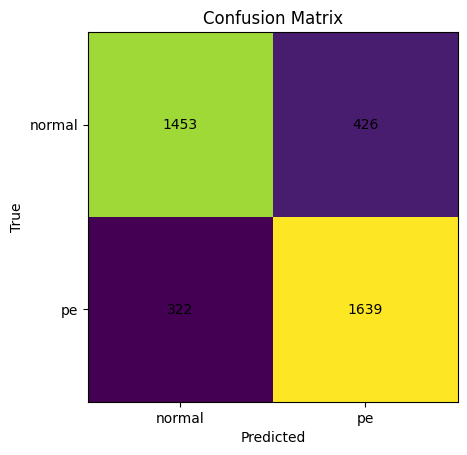

In [23]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

all_logits, all_targets = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        all_logits.append(logits.cpu().numpy())
        all_targets.append(y.numpy())

logits = np.concatenate(all_logits, axis=0)
targets = np.concatenate(all_targets, axis=0)

# predicted class
preds = logits.argmax(1)

# metrics
print(classification_report(targets, preds, target_names=classes, digits=4))

# AUROC (binary case)
if logits.shape[1] == 2:
    probs_pos = (logits[:, 1] - logits[:, 1].min()) / (logits[:, 1].ptp() + 1e-9)
    try:
        auc = roc_auc_score(targets, probs_pos)
        print("AUROC:", round(auc, 4))
    except Exception as e:
        print("AUROC not available:", e)

# confusion matrix
cm = confusion_matrix(targets, preds)
print("Confusion matrix:\n", cm)

# quick plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.show()